# Homework 4: Structure From Motion with Bundle Adjustment

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
from os import path as os_path
file_path = os_path.dirname(os_path.realpath(''))
img_dir = file_path + "/HW4/buddha_images"

Define Camera Intrinsics (K) based on IPhone Specs given in class.<br>
Important Note: Images 2 and 3 were ignored.

In [2]:
# Camera intrinsics
K = np.array([[1600.0, 0.0, 960.0],
              [0.0, 1600.0, 540.0],
              [0.0,0.0,1.0]])

image_list = []
for image in sorted(os.listdir(img_dir)):
    if image[-4:].lower() == '.jpg' or image[-4:].lower() == '.png':
        image_list.append(img_dir + '/' + image)

imgs = []
for file_path1 in image_list: 
    imgs.append(cv2.imread(file_path1))

# Find Feature Matches

In [3]:
def get_all_matches(imgs, print_matches=False):
    # Same Hyperparameter settings as HW3
    sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    all_matches = []

    for i in range(len(imgs)-1):
        
        key_points_0, desc_0 = sift.detectAndCompute(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY), None)
        key_points_1, desc_1 = sift.detectAndCompute(cv2.cvtColor(imgs[i+1], cv2.COLOR_BGR2GRAY), None)

        matches = flann.knnMatch(desc_0,desc_1,k=2)

        good = []
        for m, n in matches:
            if m.distance < 0.70 * n.distance:
                good.append(m)

        src_pts = np.float32([key_points_0[m.queryIdx].pt for m in good])
        dst_pts = np.float32([key_points_1[m.trainIdx].pt for m in good])
        all_matches.append((src_pts, dst_pts))

        if print_matches: print("Image: ", i, ", ", i+1, " Matches: ", len(all_matches[i][0]))

    return all_matches

In [4]:
print("Feature Matches: ")
feature_matches = get_all_matches(imgs, print_matches=True)

Feature Matches: 
Image:  0 ,  1  Matches:  752
Image:  1 ,  2  Matches:  499
Image:  2 ,  3  Matches:  542
Image:  3 ,  4  Matches:  728
Image:  4 ,  5  Matches:  737
Image:  5 ,  6  Matches:  461
Image:  6 ,  7  Matches:  518
Image:  7 ,  8  Matches:  501
Image:  8 ,  9  Matches:  534
Image:  9 ,  10  Matches:  807
Image:  10 ,  11  Matches:  483
Image:  11 ,  12  Matches:  371
Image:  12 ,  13  Matches:  740
Image:  13 ,  14  Matches:  755
Image:  14 ,  15  Matches:  816
Image:  15 ,  16  Matches:  878
Image:  16 ,  17  Matches:  822
Image:  17 ,  18  Matches:  1001
Image:  18 ,  19  Matches:  991
Image:  19 ,  20  Matches:  779
Image:  20 ,  21  Matches:  622


In [5]:
feature_0, feature_1 = feature_matches[0]

# Fundamental Matrix
From https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html#:~:text=In%20simple%20words%2C%20Fundamental%20Matrix,using%208%2Dpoint%20algorithm

An alternative method that calculates the fundamental matrix using RANSAC was also implemented in the fundamental_matrix.py utility script. The similar OpenCV method was utilized in the end for robustness.

In [6]:
from fundamental_matrix import get_fundamental_matrix, draw_lines

fundamental_matrices = []
inlier_pts = []
for i in range(len(imgs)-1):
    F, mask, (pts1,pts2) = get_fundamental_matrix(feature_matches[i][0],feature_matches[i][1])
    fundamental_matrices.append(F)
    inlier_pts.append((pts1,pts2))

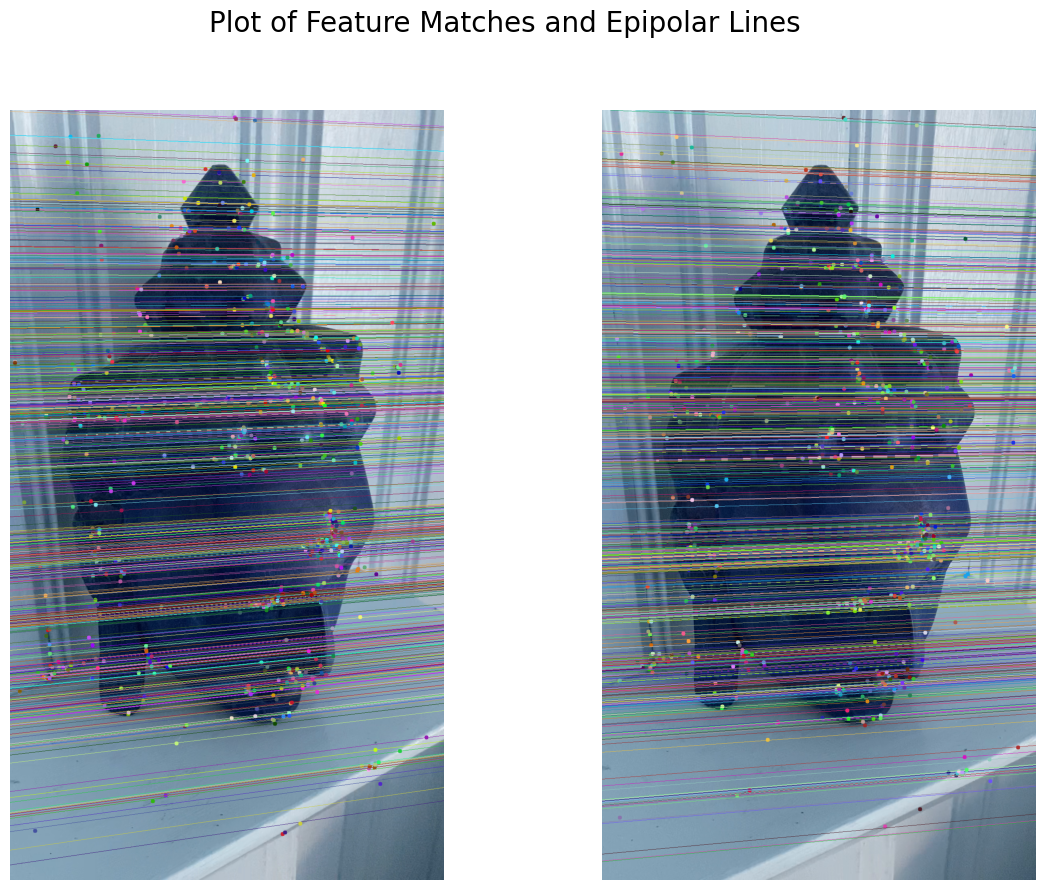

In [7]:
# Which set of images to show
show_index = 3

# Create and Draw Epipolar Lines
lines1 = cv2.computeCorrespondEpilines(feature_matches[show_index][1].reshape(-1,1,2), 2,fundamental_matrices[show_index])
lines1 = lines1.reshape(-1,3)
img_left, _ = draw_lines(np.copy(imgs[show_index]),np.copy(imgs[show_index+1]),lines1,feature_matches[show_index][0],feature_matches[show_index][1])

lines2 = cv2.computeCorrespondEpilines(feature_matches[show_index][0].reshape(-1,1,2), 1,fundamental_matrices[show_index])
lines2 = lines2.reshape(-1,3)
img_right, _ = draw_lines(np.copy(imgs[show_index+1]),np.copy(imgs[show_index]),lines2,feature_matches[show_index][1],feature_matches[show_index][0])

plt.figure(figsize = (14,10))
plt.subplot(121),plt.imshow(img_left)
plt.axis('off')
plt.subplot(122),plt.imshow(img_right)
plt.axis('off')
plt.suptitle('Plot of Feature Matches and Epipolar Lines', fontsize=20)
plt.show()


# Find Essential Matrix
Note: Direct Manual computation of Fundamental Matrix and Essential Matrix can be found in the fundamental_matrix.py script.<br>
For the purposes of this Homework, OpenCV functions will be used for robustness and continuity.

In [8]:
def get_essential_matrix(points1, points2):
    # Essential matrix
    essential_matrix, em_mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
    # Only keep inlier points
    points1 = points1[em_mask.ravel() == 1]
    points2 = points2[em_mask.ravel() == 1]

    return essential_matrix, em_mask, (points1, points2)

In [9]:
essential_matrix, em_mask, (feature_0, feature_1) = get_essential_matrix(feature_0, feature_1)

# Recover Pose
Recover Camera Pose from the essential matrix using cv2.recoverPose and apply cheirality checks.

In [10]:
def get_pose(essential_matrix, em_mask, pts1, pts2):
    _, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, pts1, pts2, K)

    transformation_matrix = np.hstack((rot_matrix, tran_matrix))

    # Apply Cheirality check to points
    f_pts1 = pts1[em_mask.ravel() > 0]
    f_pts2 = pts2[em_mask.ravel() > 0]

    return transformation_matrix, f_pts1, f_pts2

In [11]:
transformation_matrix_0 = np.eye(4)[:3,:]
transformation_matrix_1, feature_0, feature_1 = get_pose(essential_matrix, em_mask, feature_0, feature_1)

# Triangulation
Triangulates 3d points from 2d vectors and projection matrices and returns projection matrix of first camera, projection matrix of second camera, point cloud 

In [12]:
def triangulation(K, transformation0, transformation1, features0, features1) -> tuple:

    # Get Projection Matrix from Transformation Matrix
    projection0 = K @ transformation0
    projection1 = K @ transformation1

    pt_cloud = cv2.triangulatePoints(projection0, projection1, features0.T, features1.T)
    return features0.T, features1.T, (pt_cloud / pt_cloud[3])    


In [13]:
feature_0_new, feature_1_new, points_3d = triangulation(K, transformation_matrix_0, transformation_matrix_1, feature_0, feature_1)

# Reprojection Error
Calculates the distance between the projected points and the actual points.<br>
Code taken from: https://github.com/Yashas120/Multiview-3D-Reconstruction/blob/main/sfm.py 

In [14]:
def reprojection_error(obj_points, image_points, transform_matrix, K, homogenity) ->tuple:
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    if homogenity == 1:
        obj_points = cv2.convertPointsFromHomogeneous(obj_points.T)
    image_points_calc, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points_calc = np.float32(image_points_calc[:, 0, :])
    total_error = cv2.norm(image_points_calc, np.float32(image_points.T) if homogenity == 1 else np.float32(image_points), cv2.NORM_L2)
    return total_error / len(image_points_calc), obj_points

In [15]:
error, points_3d_new = reprojection_error(points_3d, feature_1_new, transformation_matrix_1, K, homogenity = 1)
print("REPROJECTION ERROR: ", error)

REPROJECTION ERROR:  0.008641457787073108


# PnP

We could continue to extract the point cloud and camera poses from the sequence of: <br>
* Compute the Fundamental Matrix between image pairs
* Form the Essential Matrix from the Fundamental Matrix
* Recover the Camera Transformation Matrix from the extracted features
* Find the relative translation scale (because cv2.recoverPose gives Unit-Vector Translation)
* Triangulate 3D points from the camera poses
* Perform Data Association techniques to correlate 3D points with the contributing 2D features


Or, we can use the PnP RANSAC Algorithm, which can perform these steps iteratively and returns the associated 2D image points and 3D point cloud

In [16]:
def PnP(obj_point, image_point , K, dist_coeff, rot_vector, initial) ->  tuple:
    if initial == 1:
        obj_point = obj_point[:, 0 ,:]
        image_point = image_point.T
        rot_vector = rot_vector.T 
    
    _, rot_vector_calc, tran_vector, inlier = cv2.solvePnPRansac(obj_point, image_point, K, dist_coeff, cv2.SOLVEPNP_ITERATIVE)
    # Converts a rotation matrix to a rotation vector or vice versa
    rot_matrix, _ = cv2.Rodrigues(rot_vector_calc)

    if inlier is not None:
        image_point = image_point[inlier[:, 0]]
        obj_point = obj_point[inlier[:, 0]]
        rot_vector = rot_vector[inlier[:, 0]]
    return np.hstack((rot_matrix, tran_vector)), image_point, obj_point

In [17]:
_, feature_1_pnp, points_3d_pnp = PnP(points_3d_new, feature_1_new, K, np.zeros((5, 1), dtype=np.float32), feature_0_new, initial=1)

# Correlate Image Points between Sets
Finds the common points between image 1 and 2 , image 2 and 3 <br>
returns common points of image 1-2, common points of image 2-3, mask of common points 1-2 , mask for common points 2-3 

In [18]:
def common_points(image_points_1, image_points_2, image_points_3) -> tuple:
    cm_points_1 = []
    cm_points_2 = []
    for i in range(image_points_1.shape[0]):
        a = np.where(image_points_2 == image_points_1[i, :])
        if a[0].size != 0:
            cm_points_1.append(i)
            cm_points_2.append(a[0][0])

    mask_array_1 = np.ma.array(image_points_2, mask=False)
    mask_array_1.mask[cm_points_2] = True
    mask_array_1 = mask_array_1.compressed()
    mask_array_1 = mask_array_1.reshape(int(mask_array_1.shape[0] / 2), 2)

    mask_array_2 = np.ma.array(image_points_3, mask=False)
    mask_array_2.mask[cm_points_2] = True
    mask_array_2 = mask_array_2.compressed()
    mask_array_2 = mask_array_2.reshape(int(mask_array_2.shape[0] / 2), 2)
    print(" Shape New Array", mask_array_1.shape, mask_array_2.shape)
    return np.array(cm_points_1), np.array(cm_points_2), mask_array_1, mask_array_2

# Bundle Adjustment

In [19]:
from scipy.optimize import least_squares

enable_bundle_adjustment = False

def optimal_reprojection_error(obj_points) -> np.array:
    '''
    calculates of the reprojection error during bundle adjustment
    returns error 
    '''
    transform_matrix = obj_points[0:12].reshape((3,4))
    K = obj_points[12:21].reshape((3,3))
    rest = int(len(obj_points[21:]) * 0.4)
    p = obj_points[21:21 + rest].reshape((2, int(rest/2))).T
    obj_points = obj_points[21 + rest:].reshape((int(len(obj_points[21 + rest:])/3), 3))
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    image_points, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points = image_points[:, 0, :]
    error = [ (p[idx] - image_points[idx])**2 for idx in range(len(p))]
    return np.array(error).ravel()/len(p)

def bundle_adjustment(_3d_point, opt, transform_matrix_new, K, r_error=0.5) -> tuple:
    '''
    Bundle adjustment for the image and object points
    returns object points, image points, transformation matrix
    '''
    opt_variables = np.hstack((transform_matrix_new.ravel(), K.ravel()))
    opt_variables = np.hstack((opt_variables, opt.ravel()))
    opt_variables = np.hstack((opt_variables, _3d_point.ravel()))

    values_corrected = least_squares(optimal_reprojection_error, opt_variables, gtol = r_error).x
    K = values_corrected[12:21].reshape((3,3))
    rest = int(len(values_corrected[21:]) * 0.4)
    return values_corrected[21 + rest:].reshape((int(len(values_corrected[21 + rest:])/3), 3)), values_corrected[21:21 + rest].reshape((2, int(rest/2))).T, values_corrected[0:12].reshape((3,4))

# Loop for All Images

In [20]:
total_points = np.zeros((1, 3))
total_colors = np.zeros((1, 3))

feature_0_loop = feature_0_new
feature_1_loop = feature_1_pnp
points_3d_loop = points_3d_pnp

transform_matrix_0 = np.copy(transformation_matrix_0)
transform_matrix_1 = np.copy(transformation_matrix_1)

transformation_matrices = []
transformation_matrices.append(transform_matrix_0)
transformation_matrices.append(transform_matrix_1)


for i in tqdm(range(len(image_list)-2)):
    # Find and Match Features
    features_cur, features_2 = feature_matches[i+1]
    
    if i != 0:
        # Perform Triangulation to get 3D points
        feature_0_loop, feature_1_loop, points_3d_loop = triangulation(K, transform_matrix_0, transform_matrix_1, feature_0_loop, feature_1_loop)
        feature_1_loop = feature_1_loop.T
        points_3d_loop = cv2.convertPointsFromHomogeneous(points_3d_loop.T)
        points_3d_loop = points_3d_loop[:, 0, :]
    
    # Finds common points between images
    cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = common_points(feature_1_loop, features_cur, features_2)
    cm_points_2 = features_2[cm_points_1]
    cm_points_cur = features_cur[cm_points_1]

    # Performs PnP
    transform_matrix_2, cm_points_2, points_3d_loop = PnP(points_3d_loop[cm_points_0], cm_points_2, K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial = 0)

    error, points_3d_loop = reprojection_error(points_3d_loop, cm_points_2, transform_matrix_2, K, homogenity = 0)

    cm_mask_0, cm_mask_1, points_3d_loop = triangulation(K, transform_matrix_1, transform_matrix_2, cm_mask_0, cm_mask_1)
    error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_2, K, homogenity = 1)
    print("Reprojection Error: ", error)

    # takes a long time to run
    if enable_bundle_adjustment:
        points_3d_loop, cm_mask_1, transform_matrix_2 = bundle_adjustment(points_3d_loop, cm_mask_1, transform_matrix_2, K)
        error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_2, K, homogenity = 0)
        print("Bundle Adjusted error: ",error)
        total_points = np.vstack((total_points, points_3d_loop))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([cv2.cvtColor(imgs[i+2], cv2.COLOR_BGR2RGB)[l[1], l[0]] for l in points_left])
        total_colors = np.vstack((total_colors, color_vector))
    else:
        total_points = np.vstack((total_points, points_3d_loop[:, 0, :]))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([cv2.cvtColor(imgs[i+2], cv2.COLOR_BGR2RGB)[l[1], l[0]] for l in points_left.T])
        total_colors = np.vstack((total_colors, color_vector)) 

    transformation_matrices.append(transform_matrix_2)

    transform_matrix_0 = np.copy(transform_matrix_1)
    transform_matrix_1 = np.copy(transform_matrix_2)
    feature_0_loop = np.copy(features_cur)
    feature_1_loop = np.copy(features_2)

  0%|          | 0/20 [00:00<?, ?it/s]

 Shape New Array (386, 2) (386, 2)
Reprojection Error:  14.16674462252388


  5%|▌         | 1/20 [00:00<00:12,  1.56it/s]

 Shape New Array (335, 2) (335, 2)
Reprojection Error:  2.736369867606357


 10%|█         | 2/20 [00:01<00:10,  1.69it/s]

 Shape New Array (475, 2) (475, 2)
Reprojection Error:  6.0239043389008105


 15%|█▌        | 3/20 [00:02<00:12,  1.38it/s]

 Shape New Array (412, 2) (412, 2)
Reprojection Error:  42.22111420078538


 20%|██        | 4/20 [00:02<00:11,  1.38it/s]

 Shape New Array (246, 2) (246, 2)
Reprojection Error:  15.498797853938145


 25%|██▌       | 5/20 [00:03<00:08,  1.71it/s]

 Shape New Array (325, 2) (325, 2)
Reprojection Error:  50.65737720461316


 30%|███       | 6/20 [00:03<00:07,  1.77it/s]

 Shape New Array (287, 2) (287, 2)
Reprojection Error:  1.8225666738514075


 35%|███▌      | 7/20 [00:04<00:06,  1.90it/s]

 Shape New Array (317, 2) (317, 2)
Reprojection Error:  57.43710992021942


 40%|████      | 8/20 [00:04<00:06,  1.91it/s]

 Shape New Array (551, 2) (551, 2)
Reprojection Error:  7.265332637150018


 45%|████▌     | 9/20 [00:06<00:08,  1.25it/s]

 Shape New Array (219, 2) (219, 2)
Reprojection Error:  234.10811820359905


 50%|█████     | 10/20 [00:06<00:06,  1.57it/s]

 Shape New Array (202, 2) (202, 2)
Reprojection Error:  55.590595597894854


 55%|█████▌    | 11/20 [00:06<00:04,  1.97it/s]

 Shape New Array (551, 2) (551, 2)
Reprojection Error:  10.82610002061767


 60%|██████    | 12/20 [00:07<00:05,  1.46it/s]

 Shape New Array (424, 2) (424, 2)
Reprojection Error:  61.23923554290434


 65%|██████▌   | 13/20 [00:08<00:04,  1.43it/s]

 Shape New Array (422, 2) (422, 2)
Reprojection Error:  122.9847620974766


 70%|███████   | 14/20 [00:09<00:04,  1.40it/s]

 Shape New Array (436, 2) (436, 2)
Reprojection Error:  6.9487787771405


 75%|███████▌  | 15/20 [00:09<00:03,  1.37it/s]

 Shape New Array (398, 2) (398, 2)
Reprojection Error:  15.384099504471408


 80%|████████  | 16/20 [00:10<00:02,  1.39it/s]

 Shape New Array (542, 2) (542, 2)
Reprojection Error:  15.64480216931513


 85%|████████▌ | 17/20 [00:11<00:02,  1.23it/s]

 Shape New Array (506, 2) (506, 2)
Reprojection Error:  71.20843317917982


 90%|█████████ | 18/20 [00:12<00:01,  1.17it/s]

 Shape New Array (353, 2) (353, 2)
Reprojection Error:  27.94914351465745


 95%|█████████▌| 19/20 [00:13<00:00,  1.30it/s]

 Shape New Array (231, 2) (231, 2)
Reprojection Error:  9.25838889477343


100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


# Start GTSAM

This section takes heavily from: <br>
https://github.com/gtbook/gtsam-examples/blob/main/SFMExample.ipynb <br>
and <br>
https://gtsam-jlblanco-docs.readthedocs.io/en/latest/StructureFromMotion.html

Camera observations of landmarks (i.e. pixel coordinates) will be stored as Point2 (x, y).

Each variable in the system (poses and landmarks) must be identified with a unique key. We can either use simple integer keys (1, 2, 3, ...) or symbols (X1, X2, L1). Here we will use Symbols

In GTSAM, measurement functions are represented as 'factors'. Several common factors have been provided with the library for solving robotics/SLAM/Bundle Adjustment problems. Here we will use Projection factors to model the camera's landmark observations. Also, we will initialize the robot at some location using a Prior factor.

When the factors are created, we will add them to a Factor Graph. As the factors we are using are nonlinear factors, we will need a Nonlinear Factor Graph.

Finally, once all of the factors have been added to our factor graph, we will want to solve/optimize to graph to find the best (Maximum A Posteriori) set of variable values. GTSAM includes several nonlinear optimizers to perform this step. Here we use Levenberg Marquardt

The nonlinear solvers within GTSAM are iterative solvers, meaning they linearize the nonlinear functions around an initial linearization point, then solve the linear system to update the linearization point. This happens repeatedly until the solver converges to a consistent set of variable values. This requires us to specify an initial guess for each variable, held in a Values container.

In [21]:
import gtsam
from gtsam import symbol_shorthand
from gtsam import (Cal3_S2, GenericProjectionFactorCal3_S2, NonlinearFactorGraph, 
                PinholeCameraCal3_S2, Point3, Pose3, PriorFactorPoint3, PriorFactorPose3, Values)
from gtsam.utils import plot

L = symbol_shorthand.L # L is the integer key for landmarks
X = symbol_shorthand.X # X is the integer key for poses

# Define the camera calibration parameters
gtsam_camera_matrix = gtsam.Cal3_S2(
    K[0, 0], K[1, 1], 0.0, K[0, 2], K[1, 2])

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

In [22]:
# Save points and poses in GTSAM format
points = []
for pt in total_points:
    points.append(np.array(pt))

poses = []
for t in transformation_matrices:
    poses.append(Pose3(t[:3,:]))

In [23]:
# Create a factor graph
graph = NonlinearFactorGraph()

# Add a prior on pose x1. This indirectly specifies where the origin is.
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
     np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
factor = PriorFactorPose3(X(0), poses[0], pose_noise)
graph.push_back(factor)

# Simulated measurements from each camera pose, adding them to the factor graph
for i, pose in enumerate(poses):
    camera = PinholeCameraCal3_S2(pose, gtsam_camera_matrix)
    for j, point in enumerate(points):
        try:
            measurement = camera.project(point)
            factor = GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(i), L(j), gtsam_camera_matrix)
            graph.push_back(factor)
        except RuntimeError:
            # print("cheirality exception caught!")
            continue
        

Because the structure-from-motion problem has a scale ambiguity, the problem is still under-constrained Here we add a prior on the position of the first landmark. This fixes the scale by indicating the distance between the first camera and the first landmark. All other landmark positions are interpreted using this scale.

In [24]:
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = PriorFactorPoint3(L(0), points[0], point_noise)
graph.push_back(factor)
# graph.print('Factor Graph:\n')

Create the data structure to hold the initial estimate to the solution Intentionally initialize the variables off from the ground truth

In [25]:
# Make Initial Estimates and initialize a random amount off the ground truth!
initial_estimate = Values()
for i, pose in enumerate(poses):
    transformed_pose = pose.retract(0.01*np.random.randn(6, 1))
    initial_estimate.insert(X(i), transformed_pose)
for j, point in enumerate(points):
    transformed_point = point + 0.01*np.random.randn(3)
    initial_estimate.insert(L(j), transformed_point)
# initial_estimate.print('Initial Estimates:\n')

# Optimize Graph and Print Results

In [26]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)

print('Optimizing:')
result = optimizer.optimize()
# result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

Optimizing:
initial error = 1596433379248.2075
final error = 8486219509.596409


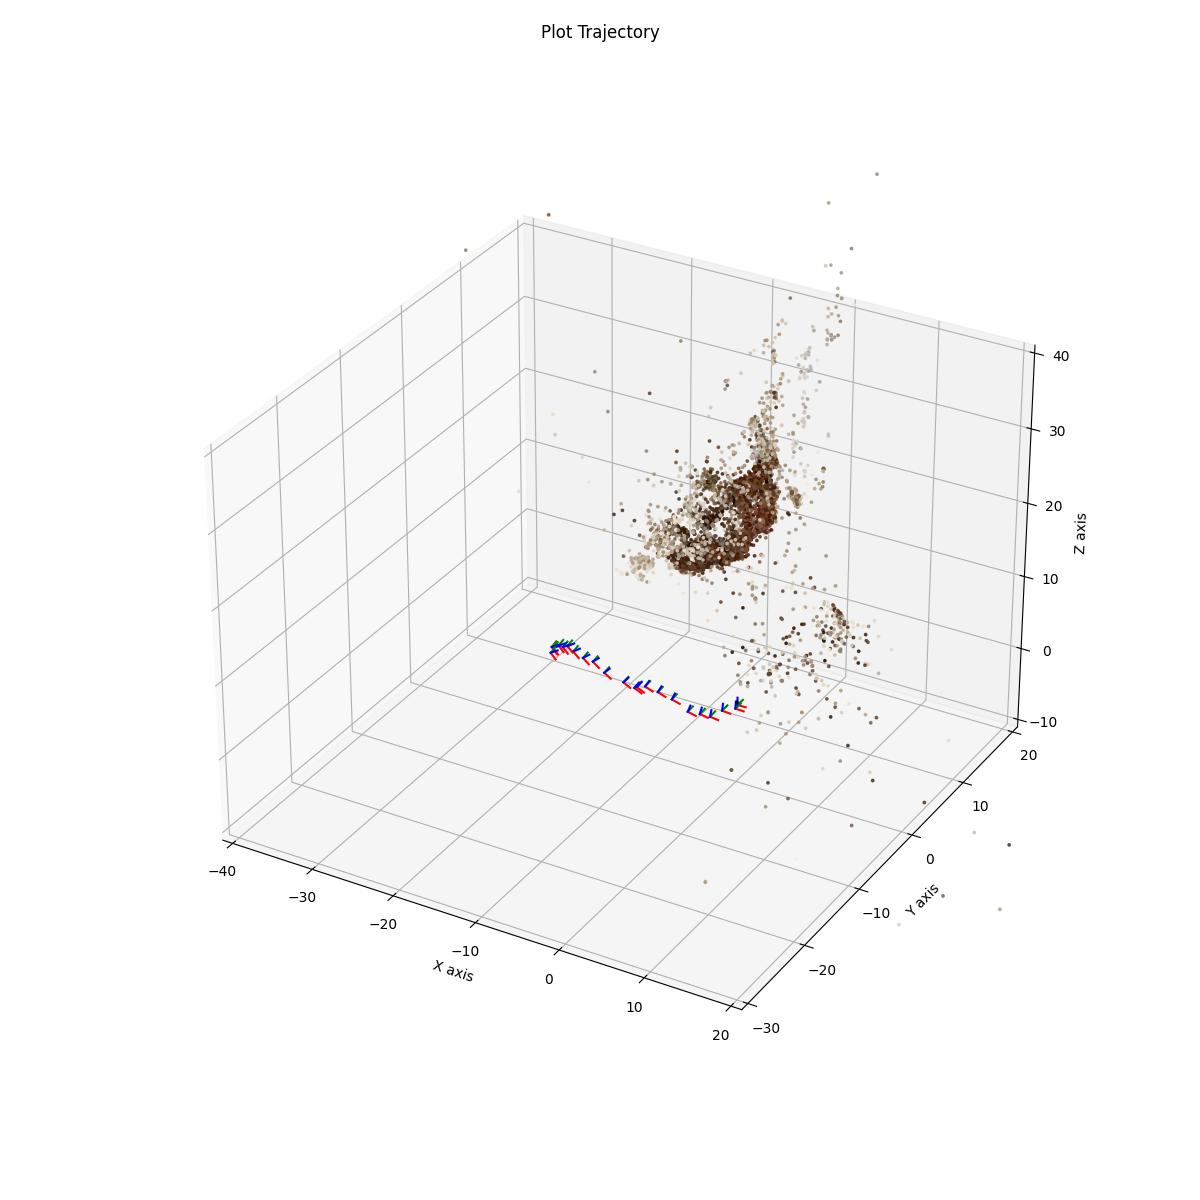

In [27]:
%matplotlib ipympl
import matplotlib.pyplot as plt 


fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=1)
gtsam.utils.plot.set_axes_equal(1)

xPts = [pt_cloud[0] for pt_cloud in points]
yPts = [pt_cloud[1] for pt_cloud in points]
zPts = [pt_cloud[2] for pt_cloud in points]

ax.scatter(xPts, yPts, zPts, s=3, c=total_colors/255)

ax.set_xlim3d(-40, 20)
ax.set_ylim3d(-30, 20)
ax.set_zlim3d(-10, 40)

plt.show()